<a href="https://colab.research.google.com/github/faizankshaikh/chessDetection/blob/main/code/1.2%20train_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries and modules
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

from tensorflow.keras import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, GlobalMaxPool2D, Dense, Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# define data dir
data_dir = Path('/content/drive/MyDrive/MAID/502 CI/project/data')

In [3]:
# load training metadata
train_data = pd.read_csv(data_dir / 'train' / 'annot_csv' / 'train.csv')
train_data.head()

,filename,label,xcenter,ycenter,width,height
0,image_1h3.png,whiteKing,203,151,26,26
1,image_2h4.png,blackQueen,203,125,26,26
2,image_1a5.png,whiteKing,21,99,26,26
3,image_3g2.png,whiteQueen,177,177,26,26
4,image_1f4.png,whiteKing,151,125,26,26


In [4]:
# load validation metadata
valid_data = pd.read_csv(data_dir / 'valid' / 'annot_csv' / 'valid.csv')
valid_data.head()

,filename,label,xcenter,ycenter,width,height
0,image_2h3.png,blackQueen,203,151,26,26
1,image_0h8.png,blackKing,203,21,26,26
2,image_1f1.png,whiteKing,151,203,26,26
3,image_0e4.png,blackKing,125,125,26,26
4,image_0c6.png,blackKing,73,73,26,26


In [5]:
# create dictionary to convert labels to class names
label_to_class_names = {
    0: 'blackKing',
    1: 'whiteKing',
    2: 'blackQueen',
    3: 'whiteQueen',
}

In [6]:
# create dictionary to convert class names to labels
## this is done by inverting the previous dictionary
class_names_to_label = {v: k for k, v in label_to_class_names.items()}

In [7]:
# create dictionary to one-hot encode class names
encode_classname = {
    'blackKing': [1, 0, 0, 0],
    'whiteKing': [0, 1, 0, 0],
    'blackQueen': [0, 0, 1, 0],
    'whiteQueen': [0, 0, 0, 1]
}

In [8]:
# get training metadata and store it in numpy arrays
train_x = []
train_y_class = []
train_y_reg = []
for idx, row in train_data.iterrows():
    img_name = row.iloc[0]
    xcenter = row.iloc[2]
    ycenter = row.iloc[3]


    _stem = Path(img_name).stem
    label = int(_stem.split('_')[1][0])
    class_name = label_to_class_names[label]
    img_path = str(data_dir / "train" / 'images' / class_name / img_name)

    img = plt.imread(img_path)
    train_x.append(img)
    train_y_class.append(encode_classname[class_name])
    train_y_reg.append([xcenter, ycenter])

train_x = np.stack(train_x)
train_y_class = np.stack(train_y_class)
train_y_reg = np.stack(train_y_reg).astype(float)

In [9]:
train_x.shape, train_y_class.shape, train_y_reg.shape

((204, 224, 224, 3), (204, 4), (204, 2))

In [10]:
# get validation metadata and store it in numpy arrays
valid_x = []
valid_y_class = []
valid_y_reg = []
for idx, row in valid_data.iterrows():
    img_name = row.iloc[0]
    xcenter = row.iloc[2]
    ycenter = row.iloc[3]


    _stem = Path(img_name).stem
    label = int(_stem.split('_')[1][0])
    class_name = label_to_class_names[label]
    img_path = str(data_dir / "valid" / 'images' / class_name / img_name)

    img = plt.imread(img_path)
    valid_x.append(img)
    valid_y_class.append(encode_classname[class_name])
    valid_y_reg.append([xcenter, ycenter])

valid_x = np.stack(valid_x)
valid_y_class = np.stack(valid_y_class)
valid_y_reg = np.stack(valid_y_reg).astype(float)

In [11]:
valid_x.shape, valid_y_class.shape, valid_y_reg.shape

((52, 224, 224, 3), (52, 4), (52, 2))

In [12]:
train_y_reg[:5]

array([[203., 151.],
       [203., 125.],
       [ 21.,  99.],
       [177., 177.],
       [151., 125.]])

In [13]:
valid_y_reg[:5]

array([[203., 151.],
       [203.,  21.],
       [151., 203.],
       [125., 125.],
       [ 73.,  73.]])

In [14]:
# load pretrained VGG model and add layers
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

x = GlobalMaxPool2D()(vgg.layers[-1].output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
op1 = Dense(4, activation='softmax')(x)    # classification head
op2 = Dense(2, activation='linear')(x)     # regression head

model = Model(vgg.inputs, [op1, op2])

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [16]:
# compile model
## more weightage is given to classification task
model.compile(
    optimizer=Adam(0.0001, clipvalue=100), 
    loss=['categorical_crossentropy', 'mse'],
    loss_weights=[5, 0.25]
)

In [17]:
# store best model based on validation loss
model_path = data_dir / "models" / "vgg_model.hdf5"
check = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True)

In [18]:
# train model for 100 epochs
history = model.fit(
    train_x, 
    [train_y_class, train_y_reg],
    validation_data=(valid_x, [valid_y_class, valid_y_reg]),
    batch_size = 32, 
    epochs = 100, 
    callbacks = [check],
    verbose = 1
)

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 3416.9150 - dense_2_loss: 7.6491 - dense_3_loss: 13514.6777
Epoch 00001: val_loss improved from inf to 1605.75415, saving model to /content/drive/MyDrive/MAID/502 CI/project/data/models/vgg_model.hdf5
7/7 [==============================] - 40s 3s/step - loss: 3416.9150 - dense_2_loss: 7.6491 - dense_3_loss: 13514.6777 - val_loss: 1605.7542 - val_dense_2_loss: 65.8780 - val_dense_3_loss: 5105.4556
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 1221.8881 - dense_2_loss: 36.4938 - dense_3_loss: 4157.6763
Epoch 00002: val_loss improved from 1605.75415 to 734.81238, saving model to /content/drive/MyDrive/MAID/502 CI/project/data/models/vgg_model.hdf5
7/7 [==============================] - 7s 967ms/step - loss: 1221.8881 - dense_2_loss: 36.4938 - dense_3_loss: 4157.6763 - val_loss: 734.8124 - val_dense_2_loss: 8.4746 - val_dense_3_loss: 2769.7583
Epoch 3/100
7/7 [==============================] - ETA: 0s -

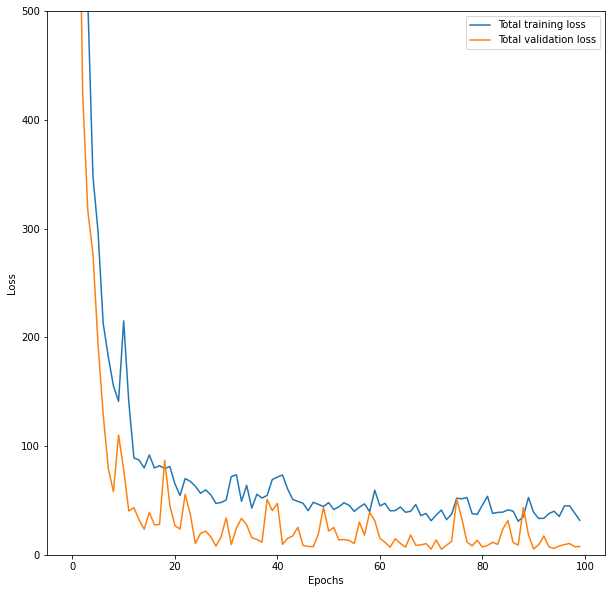

In [19]:
# plot training and validation loss
plt.figure(figsize=(10, 10))

plt.plot(history.history['loss'], label='Total training loss')
plt.plot(history.history['val_loss'], label='Total validation loss')
plt.ylim(0, 500)    # limit the plotting of high loss values
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# load best model weights
model.load_weights(model_path)

In [ ]:
# get predictions on validation set
pred_class, pred_reg = model.predict(valid_x)
pred_class[:5], pred_reg[:5]

(array([[9.7643846e-12, 4.0158678e-33, 1.0000000e+00, 2.7231967e-11],
        [9.9999976e-01, 4.9183102e-13, 6.4737492e-08, 1.4623420e-07],
        [1.7389263e-16, 1.0000000e+00, 1.9013007e-26, 2.3372250e-12],
        [9.9999893e-01, 2.3665814e-09, 1.1232881e-06, 1.4758951e-10],
        [9.9997163e-01, 1.2321541e-10, 2.8342576e-05, 2.8720276e-10]],
       dtype=float32), array([[212.74702 , 142.8202  ],
        [202.27634 ,  22.56296 ],
        [144.26714 , 195.12964 ],
        [126.380325, 123.83264 ],
        [ 75.64244 ,  75.30838 ]], dtype=float32))

In [ ]:
# print bounding box predictions of first index
xcenter, ycenter = pred_reg[0].astype(int).clip(0)
xcenter, ycenter

(212, 142)

In [ ]:
# print label predictions of first index
label_to_class_names[np.argmax(pred_class[0])]

'blackQueen'

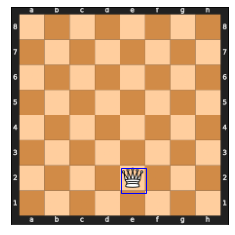

Label is whiteQueen


In [ ]:
# visualize output of model for random index in validation data
## run this cell repetitively to get different images and their predictions
idx = np.random.randint(valid_x.shape[0])

fig, ax = plt.subplots()

ax.imshow(valid_x[idx])
xcenter, ycenter = pred_reg[idx].astype(int).clip(0)
rect = patches.Rectangle((xcenter - 26/2, ycenter - 26/2), 26, 26, linewidth=1, edgecolor='b', facecolor='none')
ax.add_patch(rect)

ax.set_xticks([])
ax.set_yticks([])

plt.show()
print('Label is', label_to_class_names[np.argmax(pred_class[idx])])

In [ ]:
# evaluate model on different metrics

In [ ]:
# print actual labels of validation data
y_true = valid_y_class.argmax(axis=1)
y_true

array([2, 0, 1, 0, 0, 3, 3, 2, 3, 1, 1, 1, 2, 0, 3, 0, 1, 2, 1, 2, 1, 0,
       2, 3, 3, 0, 2, 1, 2, 0, 0, 0, 1, 2, 3, 3, 3, 3, 2, 3, 2, 1, 3, 3,
       2, 1, 1, 0, 0, 2, 1, 0])

In [ ]:
# print predicted labels of validation data
y_pred = pred_class.argmax(axis=1)
y_pred

array([2, 0, 1, 0, 0, 3, 3, 2, 3, 1, 1, 1, 2, 0, 3, 0, 1, 2, 1, 2, 1, 0,
       2, 3, 0, 0, 2, 1, 2, 0, 0, 0, 1, 2, 3, 3, 3, 3, 2, 3, 2, 1, 3, 3,
       2, 1, 1, 0, 0, 2, 1, 0])

In [ ]:
accuracy_score(y_true, y_pred)

0.9807692307692307

In [ ]:
confusion_matrix(y_true, y_pred)

array([[13,  0,  0,  0],
       [ 0, 13,  0,  0],
       [ 0,  0, 13,  0],
       [ 1,  0,  0, 12]])

In [ ]:
precision_score(y_true, y_pred, average='weighted')

0.9821428571428571

In [ ]:
recall_score(y_true, y_pred, average='weighted')

0.9807692307692307